In [40]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.layers import GRU, Dense
import matplotlib.dates as mdates
from datetime import timedelta

In [41]:
# Load the dataset
df = pd.read_csv('Bangalore_AQI_Dataset.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
df.set_index('Date', inplace=True)

features = ['AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
data = df[features]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [42]:
# Normalize the data
aqi_scaler = MinMaxScaler()
df['AQI_scaled'] = aqi_scaler.fit_transform(df[['AQI']])

In [43]:
# Create sequences for LSTM model
def create_sequences_target_only(data, window_size, target_index=0):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])      
        y.append(data[i, target_index])
    return np.array(X), np.array(y)

# Define the window size
window_size = 30
X, y = create_sequences_target_only(scaled_data, window_size, target_index=0)

# Reshape data to be in the form (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], len(features)))

In [44]:
# Split into training and testing datasets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [45]:
# Create the GRU model
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(window_size, len(features)), kernel_regularizer=l2(0.001)))
model.add(GRU(64, kernel_regularizer=l2(0.00005)))
model.add(Dense(1))  # Predict only AQI

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Implement early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model with specified epochs and early stopping
epochs = 40
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=[early_stop, lr_scheduler], verbose=1)

Epoch 1/40
57/57 [==============================] - 6s 42ms/step - loss: 0.0293 - val_loss: 0.0187 - lr: 0.0010
Epoch 2/40
57/57 [==============================] - 2s 30ms/step - loss: 0.0173 - val_loss: 0.0131 - lr: 0.0010
Epoch 3/40
57/57 [==============================] - 2s 30ms/step - loss: 0.0141 - val_loss: 0.0117 - lr: 0.0010
Epoch 4/40
57/57 [==============================] - 2s 36ms/step - loss: 0.0129 - val_loss: 0.0110 - lr: 0.0010
Epoch 5/40
57/57 [==============================] - 2s 38ms/step - loss: 0.0124 - val_loss: 0.0109 - lr: 0.0010
Epoch 6/40
57/57 [==============================] - 2s 38ms/step - loss: 0.0119 - val_loss: 0.0098 - lr: 0.0010
Epoch 7/40
57/57 [==============================] - 2s 38ms/step - loss: 0.0117 - val_loss: 0.0102 - lr: 0.0010
Epoch 8/40
57/57 [==============================] - 2s 36ms/step - loss: 0.0113 - val_loss: 0.0092 - lr: 0.0010
Epoch 9/40
57/57 [==============================] - 2s 36ms/step - loss: 0.0107 - val_loss: 0.0091 - lr:

In [49]:
# Predicting on the test set
y_pred = model.predict(X_test)

y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Rescale predictions and actual values back to original AQI scale
y_pred_rescaled = aqi_scaler.inverse_transform(y_pred)
y_test_rescaled = aqi_scaler.inverse_transform(y_test)

y_test_aqi = y_test[:, 0]
y_pred_aqi = y_pred[:, 0]

aqi_min = scaler.min_[0]
aqi_scale = scaler.scale_[0]

y_test_rescaled = y_test_aqi / aqi_scale + aqi_min
y_pred_rescaled = y_pred_aqi / aqi_scale + aqi_min

16/16 [==============================] - 0s 11ms/step


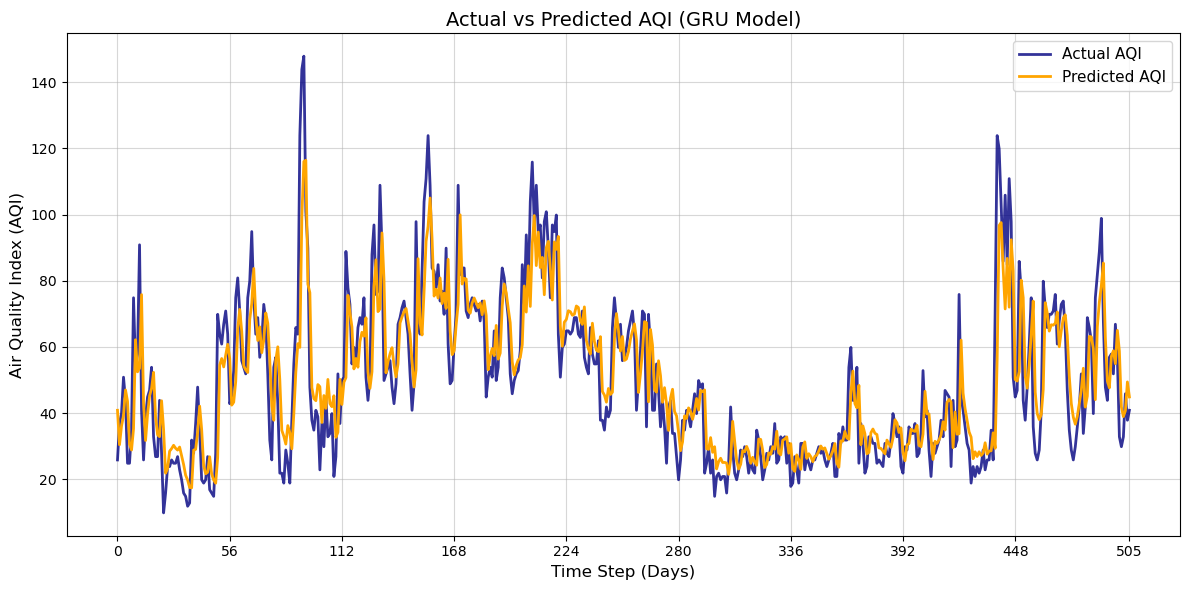

In [67]:
# Use indices instead of dates if date alignment is tricky
x_axis = np.arange(len(y_test_rescaled))

plt.figure(figsize=(12, 6))

# Plot actual AQI
plt.plot(x_axis, y_test_rescaled, label='Actual AQI', color='navy', linewidth=2, alpha=0.8)

# Plot predicted AQI with a smoother look
plt.plot(x_axis, y_pred_rescaled, label='Predicted AQI', color='orange', linewidth=2)

# Title and labels
plt.title('Actual vs Predicted AQI (GRU Model)', fontsize=14)
plt.xlabel('Time Step (Days)', fontsize=12)
plt.ylabel('Air Quality Index (AQI)', fontsize=12)

# Grid and legend
plt.grid(True, alpha=0.5)
plt.legend(loc='upper right', fontsize=11)

# Limit the number of x-ticks to avoid clutter
plt.xticks(ticks=np.linspace(0, len(x_axis)-1, 10).astype(int))

plt.tight_layout()
plt.show()

In [72]:
def forecast_future(model, last_sequence, n_days, scaler, aqi_scaler, feature_index=0):
    predictions = []
    window_size = last_sequence.shape[0]
    num_features = last_sequence.shape[1]

    current_input = last_sequence.reshape((1, window_size, num_features))

    for _ in range(n_days):
        # Predict AQI
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)

        # Create the next input sequence
        next_step = current_input[:, -1, :].copy() 
        next_step[0, feature_index] = pred       

        # Append the new step and remove the oldest one
        new_input = np.append(current_input[:, 1:, :], next_step.reshape(1, 1, num_features), axis=1)
        current_input = new_input

    # Properly inverse transform the predicted AQI values
    predictions_array = np.array(predictions).reshape(-1, 1)
    predictions_rescaled = aqi_scaler.inverse_transform(predictions_array).flatten()

    return predictions_rescaled

In [73]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 9.46
RMSE: 13.41
R²: 0.7006


In [74]:
# Use the last 30 days of data for forecasting
last_sequence = scaled_data[-window_size:]

# Forecast the next 7 days
forecasted_values = forecast_future(model, last_sequence, 7, scaler, aqi_scaler)

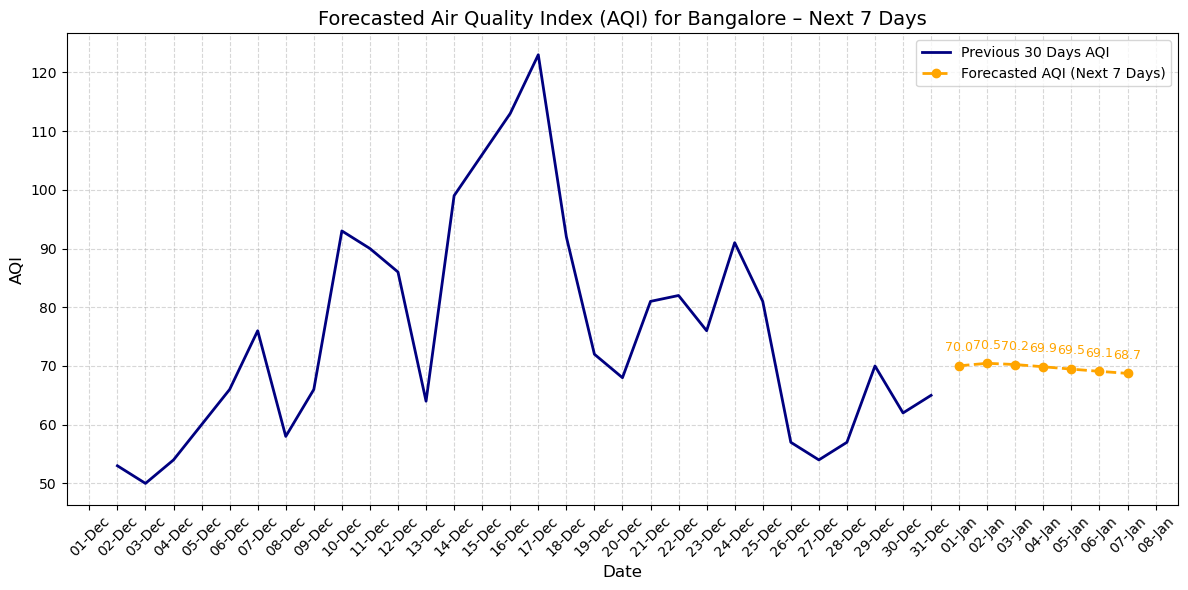

In [78]:
# Generate dates for the forecast period
forecast_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=7)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[-30:], df['AQI'].values[-30:], label='Previous 30 Days AQI', color='navy', linewidth=2)
plt.plot(forecast_dates, forecasted_values, label='Forecasted AQI (Next 7 Days)', color='orange', marker='o', linestyle='--', linewidth=2)

# Annotate each forecast point with its value
for date, val in zip(forecast_dates, forecasted_values):
    plt.text(date, val + 2, f"{val:.1f}", ha='center', va='bottom', fontsize=9, color='orange')

# Axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)
plt.title('Forecasted Air Quality Index (AQI) for Bangalore – Next 7 Days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

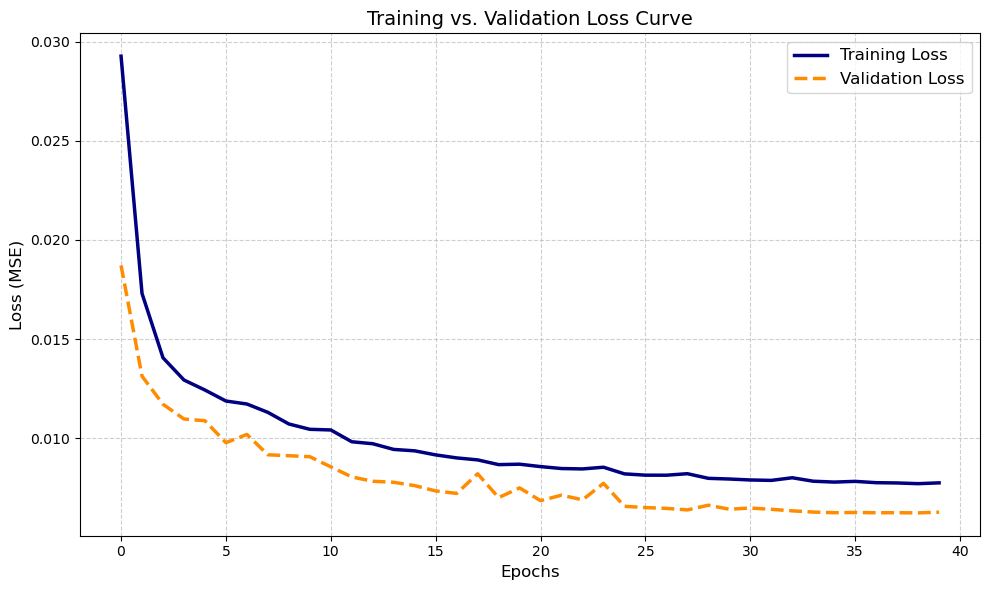

In [81]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(history.history['loss'], label='Training Loss', color='navy', linewidth=2.5, linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange', linewidth=2.5, linestyle='--')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs. Validation Loss Curve', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()